In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time 
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
mjd_unixtimestamp_offset = 10587.5
seconds_in_day = 3600 * 24

def mjd2unixtimestamp(m):
    return (m - mjd_unixtimestamp_offset) * seconds_in_day

In [4]:
def process_report(path, near_start=None, near_end=None):
    report = np.fromfile(path, sep=' ').reshape((-1, 4))
    t = Time(mjd2unixtimestamp(report[:, 0]), format='unix')
    elev = np.rad2deg(np.arctan(report[:, 3] / np.sqrt(report[:, 1]**2 + report[:, 2]**2)))
    az_rad = np.arctan2(report[:,2], -report[:,1])
    dist = np.sqrt(np.sum(report[:, 1:4]**2, axis=1))
    visible = elev >= 0
    elev_masked = elev.copy()
    elev_masked[~visible] = np.nan
    az_rad_masked = az_rad.copy()
    az_rad_masked[~visible] = np.nan
    dist_masked = dist.copy()
    dist_masked[~visible] = np.nan
    sel_near = np.ones(t.size, dtype='bool')
    if near_start is not None:
        sel_near = sel_near & (t.datetime >= near_start)
    if near_end is not None:
        sel_near = sel_near & (t.datetime <= near_end)
    
    for near in [False, True]:
        plt.figure()
        sel = sel_near if near else np.ones(t.size, dtype='bool')
        plt.plot(t.datetime[sel], elev_masked[sel])
        if not near:
            plt.xlim((t.datetime[0], t.datetime[-1]))
        plt.ylabel('Elevation (deg)', color='C0')
        plt.xlabel('UTC time')
        ax2 = plt.gca().twinx()
        ax2.plot(t.datetime[sel], dist_masked[sel], color='C1')
        ax2.set_ylabel('Distance (km)', color='C1')
        title = (
            'Tianwen-1 elevation and distance from Zhurong on periapsis pass'
            if near
            else 'Tianwen-1 elevation and distance from Zhurong over a Mars sidereal day')
        plt.title(title)
    
    plt.figure()
    ax = plt.subplot(1, 1, 1, polar=True)
    ax.plot(-az_rad_masked[~sel_near] + np.pi/2, 90 - elev_masked[~sel_near],
            label='Apoapsis passes')
    ax.plot(-az_rad_masked[sel_near] + np.pi/2, 90 - elev_masked[sel_near],
            label='Periapsis pass')
    ax.set_xticks(np.arange(0, 2*np.pi, np.pi/4))
    ax.set_xticklabels([f'{i}°' for i in np.arange(90, -360 + 90, -45) % 360])
    ax.set_yticks(range(0, 90, 15))
    ax.set_yticklabels([f'{i}°' for i in  range(90, 0, -15)]);
    ax.set_ylim([0,90])
    plt.legend()
    plt.title('Skyplot of Tianwen-1 as viewed from Zhurong')

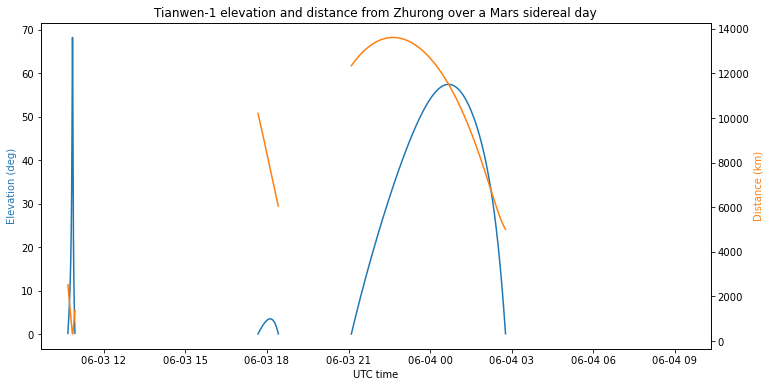

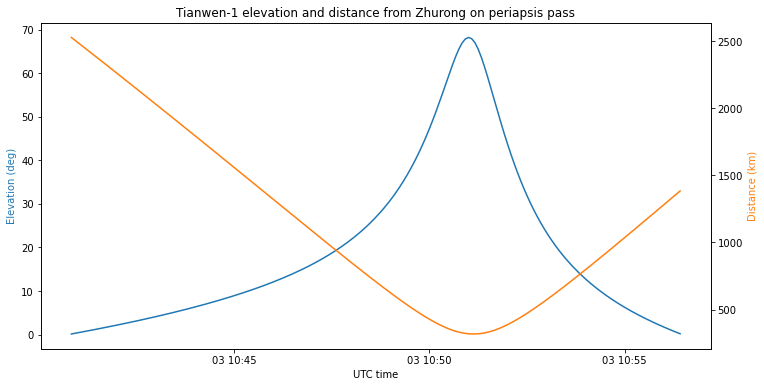

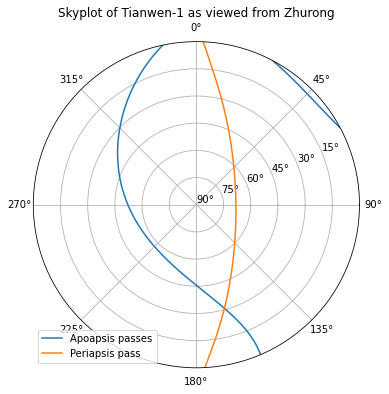

In [5]:
process_report('ZhurongTopoReportJune.txt',
               near_end=np.datetime64('2021-06-03T12:00'))

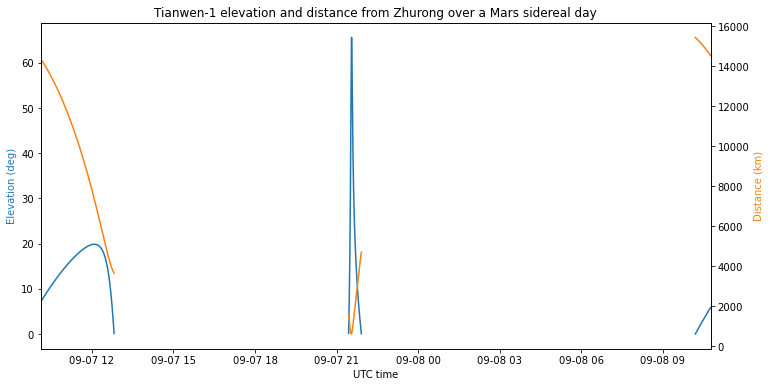

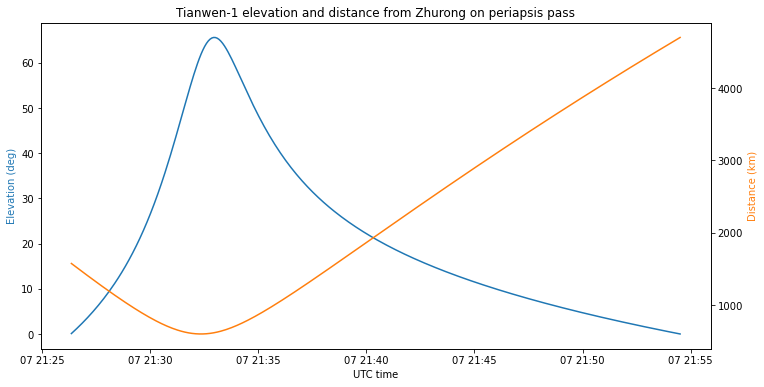

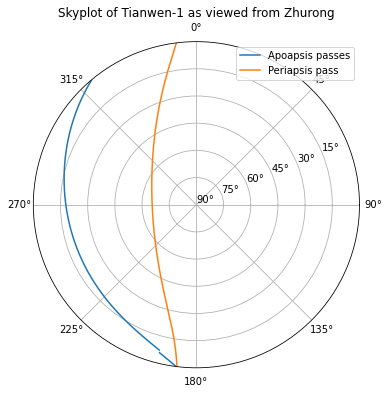

In [6]:
process_report('ZhurongTopoReportSeptember.txt',
               near_start=np.datetime64('2021-09-07T21:00'),
               near_end=np.datetime64('2021-09-07T22:00'))